# SIRS model simulation with Perturbation Trasmission

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The model

## Wiener process

In [2]:
def dW(delta_t: float) -> float:
    """Sample a random number at each call.

    Parameters:
    - delta_t (float): Time step.

    Returns:
    - float: Random number sampled.
    """
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))


## SIRS with Perturbation Trasmission

In [3]:
def Euler_Maruyama_method(t_in, t_end, N, mu, b0, b1, phi, gamma, ni, alpha, S_in, I_in, R_in):
    """Simulate a stochastic SIR model using the Euler-Maruyama method.

    Parameters:

    Parameters:
    - t_in (int): Initial time.
    - t_end (int): End time.
    - N (int): Number of steps.
    - mu (float): Parameter mu.
    - b0 (float): Parameter b0.
    - b1 (float): Parameter b1.
    - phi (float): Parameter phi.
    - gamma (float): Parameter gamma.
    - ni (int): Parameter ni.
    - alpha (float): Parameter alpha.
    - S_in (float): Initial susceptible population.
    - I_in (float): Initial infected population.
    - R_in (float): Initial recovered population.
    Returns:
    - Time steps and simulated populations.
    """
    dt = float((t_end - t_in) / N)
    TS = np.arange(t_in, t_end + dt, dt)
    assert TS.size == N + 1

    Ss = np.zeros(TS.size)
    Is = np.zeros(TS.size)
    Rs = np.zeros(TS.size)

    Ss[0] = S_in
    Is[0] = I_in
    Rs[0] = R_in

    for i in range(1, TS.size):
        t = t_in + (i - 1) * dt
        S = Ss[i - 1]
        I = Is[i - 1]
        R = Rs[i - 1]

        b0_tilde = b0 + alpha * dW(dt)
        beta = b0_tilde * (1 + b1 * np.cos(2 * np.pi * t + phi))

        Ss[i] = S + ((mu - mu * S - beta * S * I + gamma * R) * dt - (alpha / b0_tilde) * beta * S * I * dW(dt))
        Is[i] = I + ((beta * S * I - ni * I - mu * I) * dt - (alpha / b0_tilde) * beta * S * I * dW(dt))
        Rs[i] = R + (ni * I - mu * R - gamma * R) * dt

    return TS, [Ss, Is, Rs]


## Statistisc

### Explanation of R0 in an SIRS Model

In epidemiology, \( R_0 \) is a critical parameter that measures the contagiousness or transmissibility of an infectious disease within a population. 

Specifically, in the context of an SIRS (Susceptible-Infectious-Recovered-Susceptible) model, \( R_0 \) represents the average number of secondary infections produced by a single infectious individual in a fully susceptible population.

#### Key Points:

- **Definition**: \( R_0 \) is defined as the ratio of the baseline transmission rate \( \beta \) to the sum of the recovery rate \( \gamma \) and the rate at which recovered individuals lose immunity \( \nu \).

- **Formula**: 

  \[
  R_0 = \frac{\beta}{\gamma + \nu}
  \]

  where:
  - \( \beta \) is the transmission rate of the disease.
  - \( \gamma \) is the recovery rate (the rate at which infected individuals recover and move to the recovered state).
  - \( \nu \) is the rate at which recovered individuals lose immunity and become susceptible again.

- **Interpretation**: 
  - If \( R_0 > 1 \), the disease can spread in the population.
  - If \( R_0 < 1 \), the disease will likely die out over time.

This formula succinctly captures how infectious a disease is based on its transmission dynamics and the immunity dynamics within the population.

In [4]:
def calculate_R0(parameters):
    """
    Calculate the basic reproduction number R0 for an SIR-type epidemiological model.
    """
    beta_avg = parameters['b0']
    gamma = parameters['gamma']
    nu = parameters['ni']
    R0 = beta_avg / (gamma + nu)
    # Print basic reproduction number (R0)
    print(f"Basic Reproduction Number (R0): {R0:.2f}")

    # Interpretation of R0
    if R0 < 1:
        print("The infection will likely die out over time.")
    elif R0 == 1:
        print("The infection will remain stable in the population but not cause an outbreak.")
    else:
        print("The infection will likely spread and cause an epidemic.")

## Plots

### Mean infections with confidence interval

In [5]:
def plot_mean_infections_with_confidence_interval(ts, infections, num_simulations):
    """Plot the mean infection curve with a confidence interval from multiple simulations.

    Parameters:
    - ts (array): Time steps.
    - infections (array): Array of infection curves from each simulation.
    - num_simulations (int): Number of simulations.
    """
    mean_infections = np.mean(infections, axis=0)
    std_infections = np.std(infections, axis=0)
    ci = 1.96 * std_infections / np.sqrt(num_simulations)  # 95% confidence interval

    plt.figure(figsize=(10, 6))
    plt.plot(ts, mean_infections, label='Mean Infection', color='blue')
    plt.fill_between(ts, mean_infections - ci, mean_infections + ci, color='blue', alpha=0.2, label='95% CI')
    plt.title('Mean Infection Curve with 95% Confidence Interval')
    plt.xlabel('Time t (years)')
    plt.ylabel('Infectives I(t)')
    plt.legend()
    plt.grid(True)
    plt.savefig('Mean Infection Curve with 95% Confidence Interval with transmission rate perturbation.png', dpi=600, bbox_inches='tight')  # Adjust filename and DPI as needed
    plt.show()


### Wrapper for all the plots and statistics 

In [6]:
def simulate_and_plot(parameters, num_simulations=10):
    """Simulate and plot multiple stochastic SIR model simulations.

    Parameters:
    - parameters (dict): Dictionary containing simulation parameters.
    - num_simulations (int): Number of simulations to run.
    """
    plural = "simulations" if num_simulations > 1 else "simulation"
    labels_on_y = {0: "Susceptible S(t)",
                   1: "Infectives I(t)",
                   2: "Recovered R(t)"}
    
    infections = []
    peak_infections = []
    
    for n in range(0, 3):
        for r in range(num_simulations):
            ts, results = Euler_Maruyama_method(**parameters)
            
            plt.plot(ts, results[n], linewidth=0.9, label=f'Simulation {r + 1}')
            plt.grid(True)

            if n == 1:
                infections.append(results[n])
                peak_infections.append(max(results[n]))

        plt.title(f'Euler-Maruyama, {num_simulations} {plural} with transmission rate perturbation')
        plt.xlabel('Time t (years)')
        plt.ylabel(labels_on_y[n])
        plt.yscale('linear')
        plt.tight_layout()
        plt.savefig(f'Euler-Maruyama, {n} with transmission rate perturbation.png', dpi=600, bbox_inches='tight')  # Adjust filename and DPI as needed
        plt.show()
        
    # Plot mean infections with confidence interval
    infections = np.array(infections)
    plot_mean_infections_with_confidence_interval(ts, infections, num_simulations)

    # Additional statistics
    peak_infection = max(results[1])
    final_size = results[0][-1] + results[1][-1] + results[2][-1]
    print(f"Peak Infection: {peak_infection}")
    print(f"Final Size of the Epidemic: {final_size}")


# Results

Basic Reproduction Number (R0): 0.96
The infection will likely die out over time.


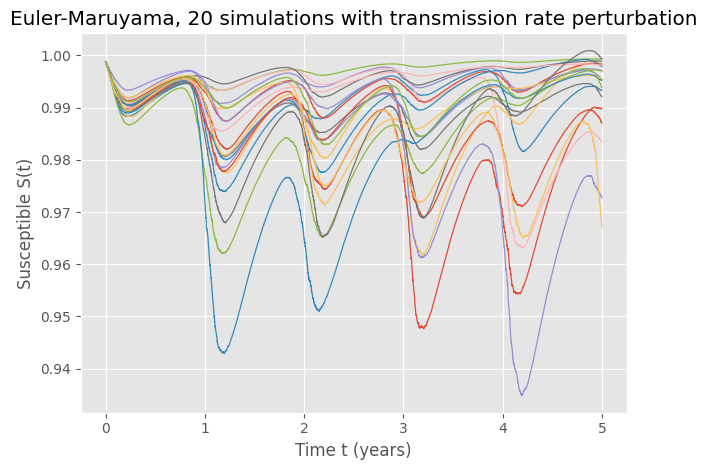

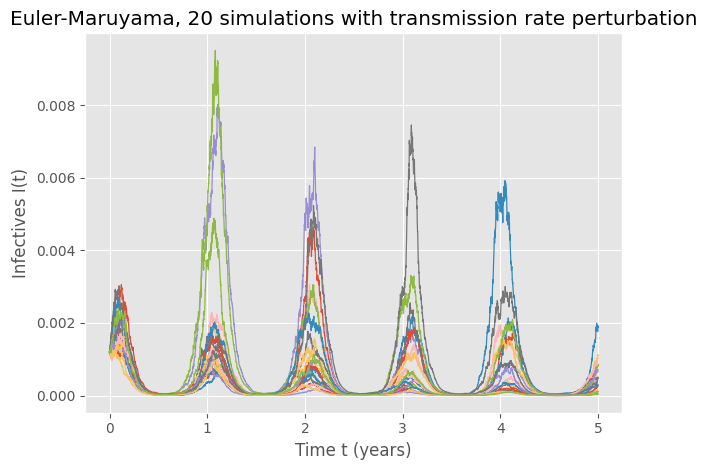

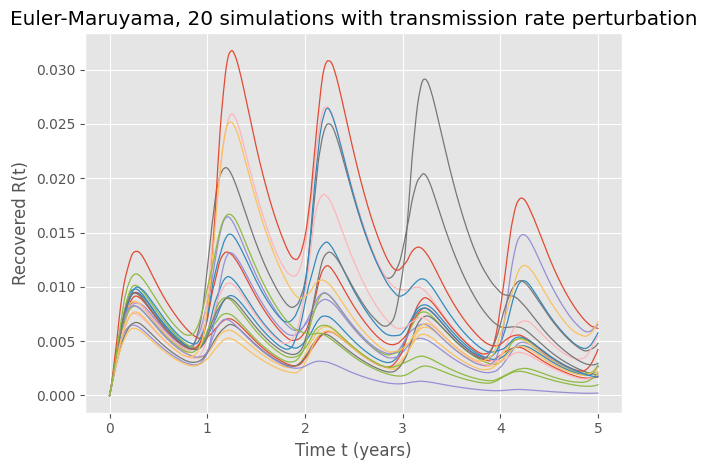

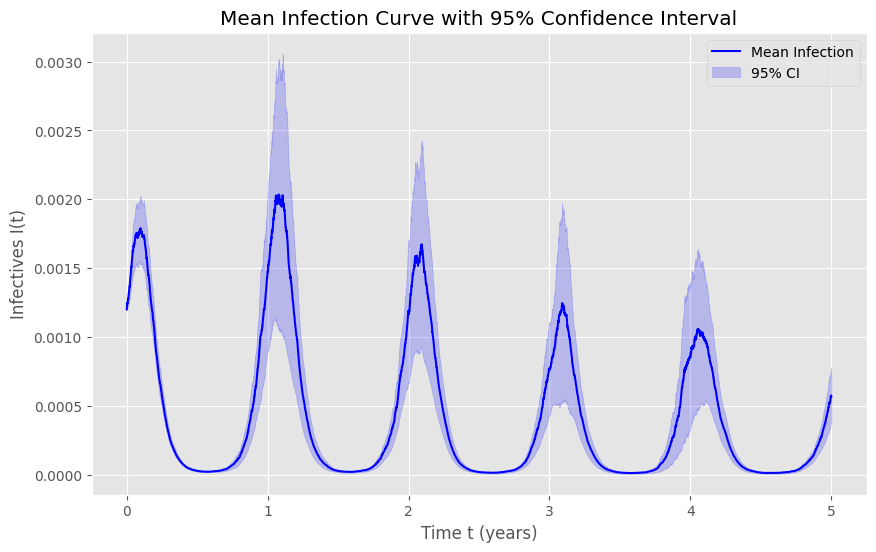

Peak Infection: 0.0023163198659237935
Final Size of the Epidemic: 1.0001242689826138


In [7]:
# Define parameters
parameters = {
    't_in': 0,
    't_end': 5,
    'N': 5000,
    'mu': 0.009,
    'b0': 36.4,
    'b1': 0.38,
    'phi': 1.07,
    'gamma': 1.8,
    'ni': 36,
    'alpha': 0.728,
    'S_in': 0.9988,
    'I_in': 0.0012,
    'R_in': 0
}

# Calculate R0
calculate_R0(parameters)
# Specify number of simulations
num_simulations = 20

# Run simulation and plot results
simulate_and_plot(parameters, num_simulations)
